<a href="https://colab.research.google.com/github/yusica09/seoul-AI-hub-study/blob/main/3%EC%A3%BC%EC%B0%A8/Speech_recognition_Wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple speech recognition

Audio 데이터를 다뤄서 학습하는 방법을 배워보도록 합시다.

머신러닝 모델을 학습하는 방법은 아래와 같습니다.

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

* 모델 완성 후 평가 지표에 따라서 모델을 평가해 봅시다.

# Dataset
* 구글 드라이브 링크를 이용해 Dataset을 다운받습니다.
    * [데이터셋 드라이브 링크](https://drive.google.com/drive/folders/1Ssxqrh6fkvr-Rkv0JtCy6cDKjAnbhnTb?usp=sharing)

```
# 기본으로 설정되어있는 Dataset path
DATASET_PATH = "/content/drive/MyDrive/Datasets"
```

## Project 설명
### Task
* 1초 길이의 오디오 음성데이터를 이용해 단어를 분류하는 것이 목표입니다.
* 주어진 데이터를 이용해 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* This code is borrowed from [Kaggle/TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).
* This is version 0.01 of the data set containing 64,727 audio files, released on August 3rd 2017.

### Baseline
* ResNet 구조와 유사한 skip connection 구조를 구현해 보자.
* 오버피팅을 방지하기 위한 다양한 방법들을 사용해보자.
* Training
    * tf.data.dataset과 model.fit()을 사용

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import librosa
import librosa.display
import matplotlib.pyplot as plt

import os
from os.path import isdir, join

import random
import copy
import sys

tf.__version__

'2.15.0'

### Import modules

* Colab 적용을 위한 변수 지정 및 드라이브 마운트

In [2]:
use_colab = True
assert use_colab in [True, False]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load dataset
* 사용할 데이터셋을 살펴봅시다.

In [4]:
if use_colab:
    DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/dataset"
else:
    DATASET_PATH = "./datasets"

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

In [5]:
speech_data = np.load(os.path.join(DATASET_PATH, "speech_wav_8000.npz"), allow_pickle=True) #npy, npz

* npz 형태의 파일은 npy의 압축형태이며, files 이름 내에 데이터를 저장하고 불러올 수 있습니다.
* files를 출력하면, 데이터가 어떤 key값으로 저장되어 있는지 확인할 수 있습니다!

In [6]:
print(speech_data.files)

['wav_vals', 'label_vals']


* 각 데이터가 어떤 형태로 저장되어 있는지 확인해봅시다.

In [7]:
print(speech_data["wav_vals"].shape, speech_data["label_vals"].shape)

(50620, 8000) (50620, 1)


* 숫자로 이뤄진 데이터가 진짜 오디오 데이터가 맞는지 확인해봅시다.

In [8]:
idx = 219 # 총 50,620개의 오디오 파일이 존재
test_audio = speech_data["wav_vals"][idx]
test_labels = speech_data["label_vals"][idx]

[ 0.01598107  0.02830634  0.06397557  0.05982646  0.09255246  0.09424292
  0.01119381 -0.0220092  -0.07077095 -0.11261097]
['down']


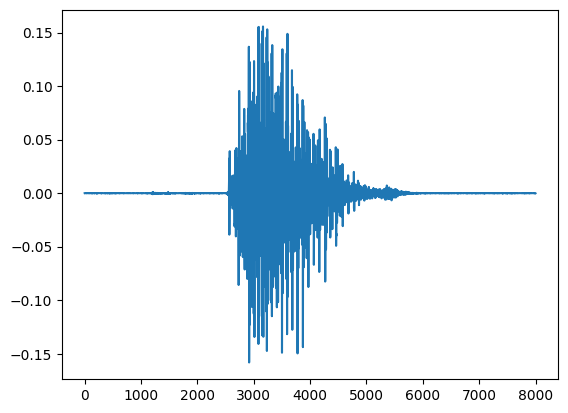

In [9]:
import IPython.display as ipd

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = test_audio
print(data[2990:3000])
plt.plot(data)

print(test_labels)
ipd.Audio(data, rate=sr)

* Conv2D(6,3) => N = 6, 3x3 size (=9)
* Conv1D(6,3) => N = 6, 3 size

* 위의 Conv1D(6,3)을 Conv2D(6,3)과 파라미터를 맞춰주고 싶다면,
  Conv1D(6,9)로 써야한다.

### Model dataset setting
* 변환된 데이터를 이용해서 학습에 활용할 데이터셋을 설정
* 전체 데이터셋을 train_test_split 함수를 이용해서 train set, test set으로 나눠보자
    * [train_test_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    
```
sklearn.model_selection.train_test_split(train, label,
                                         test_size=None,
                                         shuffle=True)
```

In [10]:
sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"],
                                                                speech_data["label_vals"],
                                                                test_size=0.1,
                                                                shuffle=True)

# for convolution layers
train_wav = train_wav.reshape([-1, sr, 1])
test_wav = test_wav.reshape([-1, sr, 1])

print(train_wav.shape)
print(test_wav.shape)
print(train_label.shape)
print(test_label.shape)

(45558, 8000, 1)
(5062, 8000, 1)
(45558, 1)
(5062, 1)


### Label 데이터를 구분해보자

In [11]:
set(speech_data["label_vals"].flatten()) # 중복제거, 고유문자

{'down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'silence',
 'stop',
 'unknown',
 'up',
 'yes'}

In [12]:
# del raw dataset for memory
del speech_data

* 총 12개의 클래스르 분류하는 작업이된다.
* unknown과 silence에는 target list 이외의 단어가 들어간다. (혹은 노이즈)

* 사전화 작업 (enumerate)

In [13]:
#target_list
label_value = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [14]:
label_value # 고유문자 사전

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10,
 'silence': 11}

* ex) label_value['down'] = 3

* Text 형태로 이뤄진 label 데이터를 학습에 사용하기 위해서 idx로 변환해 줍니다.
* 메모리를 절약하기 위해 이미 사용중인 변수를 변환
    * text 형태의 데이터를 int 형으로 변환
    * 한번 변환 후에는 text 형태가 아니기때문에 오류가 발생!


In [15]:
temp = []
for v in train_label:
    temp.append(label_value[v[0]]) # ["down"] => "down"
train_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(label_value[v[0]])
test_label = np.array(temp)

del temp

In [16]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(label_value)))

Train_Wav Demension : (45558, 8000, 1)
Train_Label Demension : (45558,)
Test_Wav Demension : (5062, 8000, 1)
Test_Label Demension : (5062,)
Number Of Labels : 12


In [17]:
train_label[0:10]

array([9, 2, 0, 4, 8, 0, 8, 0, 1, 6])

### Checkpoint setting
* 학습 전반에서 사용할 checkpoint dir을 설정한다.

In [18]:
# the save point
if use_colab:
    checkpoint_dir ='./drive/MyDrive/train_ckpt/wave/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'wave/exp1'

### Dataset 구성
* index로 구분된 label을 학습에 사용하기 위해선 두가지 방법이 있습니다.
    * Sparse loss function 사용
    * One hot vector로 변환
* One hot vector를 이용한 방법을 실습해보겠습니다.
* classes 구성을 위한 tf.one_hot
    * [tf.one_hot function](https://www.tensorflow.org/api_docs/python/tf/one_hot)

```
tf.one_hot(
    indices, depth,
    on_value=None,
    off_value=None,
    axis=None,
    dtype=None,
    name=None
)
```

In [19]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

# [0, 1, 2]

# 0 => [1, 0, 0]
# 1 => [0, 1, 0]
# 2 => [0, 0, 1]

In [20]:
batch_size = 256

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.shuffle(10000).repeat().batch(batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size)
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 8000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 8000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>


In [21]:
for t, l in train_dataset.take(1):
    print(l)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(256, 12), dtype=float32)


### Dataset 구성 검증
```
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
```

### Model 구현
* Wave 파일 데이터를 이용해 학습을 할 수 있는 모델을 구현합니다.
    * inputs = [batch_size, 8000, 1]
    * conv1 = [batch_size, 4000, 16]
    * conv2 = [batch_size, 2000, 32]
    * conv3 = [batch_size, 1000, 64]
    * desne = [batch_size, 64]
    * output = [batch_size, 12]


#### 채널 개수
* Audio : 모노 1 / 스테레오 2
* IMG : 흑백 1 / RGB 3

In [22]:
input_tensor = layers.Input(shape=(sr, 1,))
x = layers.Conv1D(16, 9, padding='same', activation='relu')(input_tensor)
skip_1 = layers.Conv1D(16, 9, strides=2, padding='same', activation='relu')(x)

x = layers.Conv1D(32, 9, padding='same', activation='relu')(skip_1)
x = tf.concat([x, skip_1], axis=-1)
skip_2 = layers.Conv1D(32, 9, strides=2, padding='same', activation='relu')(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.Conv1D(64, 9, strides=2, padding='same', activation='relu')(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.Conv1D(128, 9, strides=2, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model = tf.keras.Model(input_tensor, output_tensor)

In [23]:
# layers.Dense(12, activation='softmax') -> tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# layers.Dense(12) -> tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam(1e-4)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), # Ture or False
             optimizer=optimizer,# 1e-3
             metrics=['accuracy'])

In [24]:
# without training, just inference a model
predictions = model(train_wav[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[-0.00046316 -0.00068264 -0.0019125   0.00222419  0.00209888 -0.00244935
  -0.00223028 -0.00313574 -0.00366557 -0.0015869   0.00326525  0.00166351]]


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 8000, 16)             160       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 4000, 16)             2320      ['conv1d[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)           (None, 4000, 32)             4640      ['conv1d_1[0][0]']            
                                                                                              

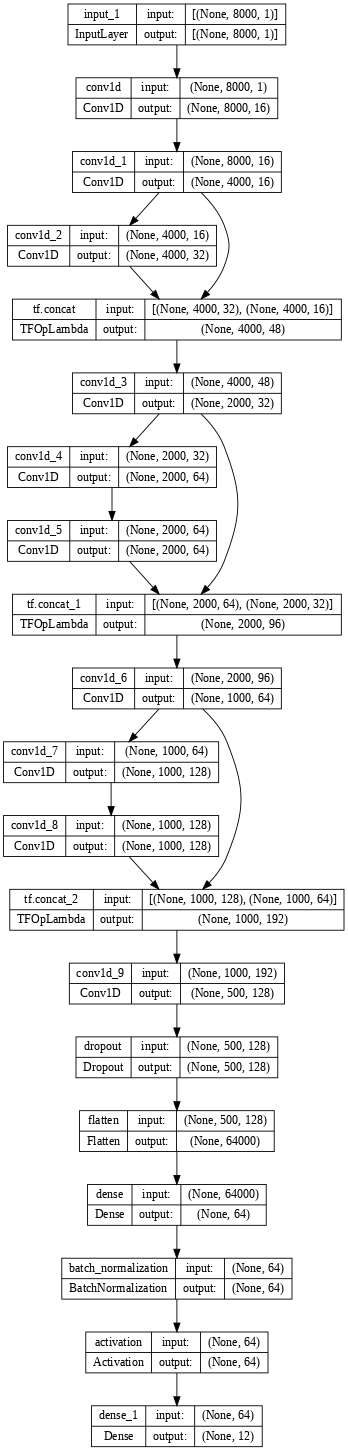

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

### Model training
* 모델 체크포인트로 저장공간을 확인 후 학습을 진행합니다.

In [27]:
max_epochs = 10
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

#early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                    #  monitor='val_loss',
                                                    #  restore_best_weights=True,
                                                    #  verbose=1)

* Learning rate를 조절하는 callback 함수도 있습니다.
* Cos 그래프 형태로 Learning rate를 줄여주는 함수를 확인해봅시다.

```python
tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps, alpha=0.0, name=None
)
```
* 코사인 디케이 함수가 어떻게 동작하는지 확인해봅시다.
```python
def decayed_learning_rate(step):
  step = min(step, decay_steps)
  cosine_decay = 0.5 * (1 + cos(pi * step / decay_steps))
  decayed = (1 - alpha) * cosine_decay + alpha
  return initial_learning_rate * decayed
```

```python
decay_steps = 100
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps)
```

* cos_decay : learning rate를 cos 모양으로 줄여주는 역할

In [28]:
cos_decay = tf.keras.experimental.CosineDecay(1e-4, # 초기 learning rate
                                               max_epochs * 1.5)#decay_steps # 에폭기준으로 언제 0이 될건지
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [29]:
# using `tf.data.Dataset`, model.fit_generator
history = model.fit(train_dataset,# dataset,
                    steps_per_epoch=len(train_wav) // batch_size,
                    epochs=max_epochs,
                    validation_data=test_dataset,
                    validation_steps=len(train_wav) // batch_size,
                    callbacks=[lr_callback,cp_callback])

# fit(
#     x=None, y=None, batch_size=None, epochs=1, verbose='auto',
#     callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
#     class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
#     validation_steps=None, validation_batch_size=None, validation_freq=1,
#     max_queue_size=10, workers=1, use_multiprocessing=False
# )

# fit_generator(
#     generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None,
#     validation_data=None, validation_steps=None, validation_freq=1,
#     class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False,
#     shuffle=True, initial_epoch=0
# )


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/10
177/177 [==============================] - ETA: 0s - loss: 2.0150 - accuracy: 0.3074


Epoch 1: val_loss improved from inf to 2.24237, saving model to ./drive/MyDrive/train_ckpt/wave/exp1
177/177 [==============================] - 103s 490ms/step - loss: 2.0150 - accuracy: 0.3074 - val_loss: 2.2424 - val_accuracy: 0.3919 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.890738147078082e-05.
Epoch 2/10
177/177 [==============================] - ETA: 0s - loss: 1.5068 - accuracy: 0.5295

177/177 [==============================] - 76s 427ms/step - loss: 1.5068 - accuracy: 0.5295 - lr: 9.8907e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.567726374370977e-05.
Epoch 3/10
177/177 [==============================] - ETA: 0s - loss: 1.2365 - accuracy: 0.6454

177/177 [==============================] - 75s 426ms/step - loss: 1.2365 - accuracy: 0.6454 - lr: 9.5677e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.045084152603522e-05.
Epoch 4/10
177/177 [==============================] - ETA: 0s - loss: 1.0494 - accuracy: 0.7186

177/177 [==============================] - 75s 426ms/step - loss: 1.0494 - accuracy: 0.7186 - lr: 9.0451e-05

Epoch 5: LearningRateScheduler setting learning rate to 8.345652895513922e-05.
Epoch 5/10
177/177 [==============================] - ETA: 0s - loss: 0.8805 - accuracy: 0.7771

177/177 [==============================] - 75s 427ms/step - loss: 0.8805 - accuracy: 0.7771 - lr: 8.3457e-05

Epoch 6: LearningRateScheduler setting learning rate to 7.499999628635123e-05.
Epoch 6/10
177/177 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.8264

177/177 [==============================] - 75s 425ms/step - loss: 0.7281 - accuracy: 0.8264 - lr: 7.5000e-05

Epoch 7: LearningRateScheduler setting learning rate to 6.545084761455655e-05.
Epoch 7/10
177/177 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.8607

177/177 [==============================] - 76s 427ms/step - loss: 0.6159 - accuracy: 0.8607 - lr: 6.5451e-05

Epoch 8: LearningRateScheduler setting learning rate to 5.522642095456831e-05.
Epoch 8/10
177/177 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.8859

177/177 [==============================] - 76s 427ms/step - loss: 0.5260 - accuracy: 0.8859 - lr: 5.5226e-05

Epoch 9: LearningRateScheduler setting learning rate to 4.477356924326159e-05.
Epoch 9/10
177/177 [==============================] - ETA: 0s - loss: 0.4585 - accuracy: 0.9057

177/177 [==============================] - 76s 427ms/step - loss: 0.4585 - accuracy: 0.9057 - lr: 4.4774e-05

Epoch 10: LearningRateScheduler setting learning rate to 3.4549138945294544e-05.
Epoch 10/10
177/177 [==============================] - ETA: 0s - loss: 0.4125 - accuracy: 0.9204

177/177 [==============================] - 76s 427ms/step - loss: 0.4125 - accuracy: 0.9204 - lr: 3.4549e-05


### 학습 결과 확인
* model fit의 return 값인 history에서 학습에 대한 결과를 확인해보자

ValueError: ignored

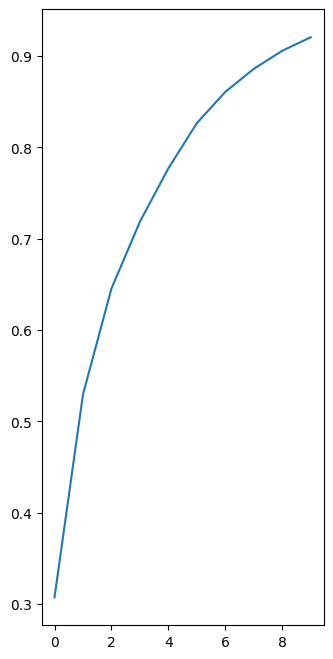

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation
* Test dataset을 이용해서 모델의 성능을 평가합니다.

In [ ]:
model.load_weights(checkpoint_dir)

In [ ]:
results = model.evaluate(test_dataset)

### 스코어 결과
* 위의 스코어는 분류모델에 적용되는 스코어입니다.
* 모델의 크기 (MB) 와 정확도를 이용해 스코어를 출력합니다.

In [ ]:
def final_score():
    print("Model params num : " + str(model.count_params()))
    print("Accuracy : " + str(results[1]))

    s = (model.count_params() * 32) / (1024 ** 2)
    score = 50 * (results[1] + min((1/s), 1))

    print("score : " + str(score))

In [ ]:
final_score()